# 🧪 Full Training of a model using MLFlow

Bienvenido al notebook que te guiará en el uso de **MLflow** para **registrar y realizar el seguimiento del entrenamiento de un modelo de regresión logística** con los datos del **Titanic**. En este tutorial, exploraremos cómo MLflow, una plataforma de código abierto para el ciclo de vida de machine learning, puede facilitar el registro de experimentos, el seguimiento de métricas y la administración de modelos en un entorno reproducible.

**El conjunto de datos del Titanic es un clásico** en la comunidad de ciencia de datos, que contiene información detallada sobre los pasajeros, como su edad, género, clase de billete y si sobrevivieron o no al desastre. Utilizaremos esta información para construir un modelo de regresión logística capaz de predecir la probabilidad de supervivencia de un pasajero en función de sus características.

A lo largo de este notebook, no solo nos enfocaremos en el entrenamiento del modelo de regresión logística, sino que también aprenderemos a aprovechar las capacidades de MLflow. Comenzaremos explorando los datos del Titanic, realizando análisis y visualizaciones para comprender mejor la distribución de las variables y los patrones presentes.

A continuación, pasaremos a la etapa de preprocesamiento de datos, donde limpiaremos y transformaremos los datos para que sean adecuados para el modelado. Durante este proceso, utilizaremos MLflow para registrar los pasos de preprocesamiento, lo que nos permitirá tener un registro completo y organizado de las transformaciones aplicadas a los datos.

Luego, nos sumergiremos en el entrenamiento de la regresión logística utilizando el conjunto de datos de entrenamiento. Aquí, MLflow desempeñará un papel fundamental al registrar los detalles del entrenamiento, incluyendo los hiperparámetros utilizados, las métricas de rendimiento y cualquier otro aspecto relevante del modelo. Esto nos permitirá realizar un seguimiento exhaustivo del proceso y facilitará la comparación de diferentes experimentos y configuraciones.

**Una vez que hayamos entrenado nuestro modelo, utilizaremos MLFlow para registrar dicho modelo en la plataforma**. Esto nos permitirá tener un registro completo de los modelos entrenados, incluidos los detalles de cada uno de ellos, como los hiperparámetros utilizados, las métricas de rendimiento y el código fuente asociado. Además, MLflow nos permitirá exportar el modelo en un formato estándar, lo que facilitará su implementación en diferentes entornos.

En resumen, este notebook te brindará la oportunidad de trabajar con MLflow y descubrir cómo esta poderosa herramienta puede simplificar y mejorar el proceso de entrenamiento de un modelo de regresión logística. A lo largo del tutorial, aprenderás a registrar experimentos, métricas y detalles del modelo, lo que te permitirá tener un seguimiento completo y reproducible de todo el proceso. ¡Así que prepárate para adentrarte en el análisis de datos del Titanic mientras exploramos las capacidades de MLflow en el entrenamiento de la regresión logística!

In [1]:
from datetime import datetime

from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd
import mlflow

from mlops_course.settings import config

## Get the Data

We will load the dataset from a CSV file and display the first few rows to get an understanding of the data.

### Read the data

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"


# Load dataset
dataframe = pd.read_csv(DATASET_URL)
dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Clean the Data

In [3]:
dataframe.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that there are missing values in the 'Age', 'Cabin', and 'Embarked' columns. We'll fill the missing values in the 'Age' column with the median age.


In [4]:
# Fill age missing values
median_age = dataframe['Age'].median()
dataframe['Age'].fillna(median_age, inplace=True)

Sex is a categorical variable composed by "male" and "female" string values. In order to train our model we need to convert them to numerical values: male=1, female=0

In [5]:
# convert string labels to numbers: male=1, female=0
le = LabelEncoder()
dataframe["Sex"] = le.fit_transform(dataframe["Sex"])

### Visualize the data

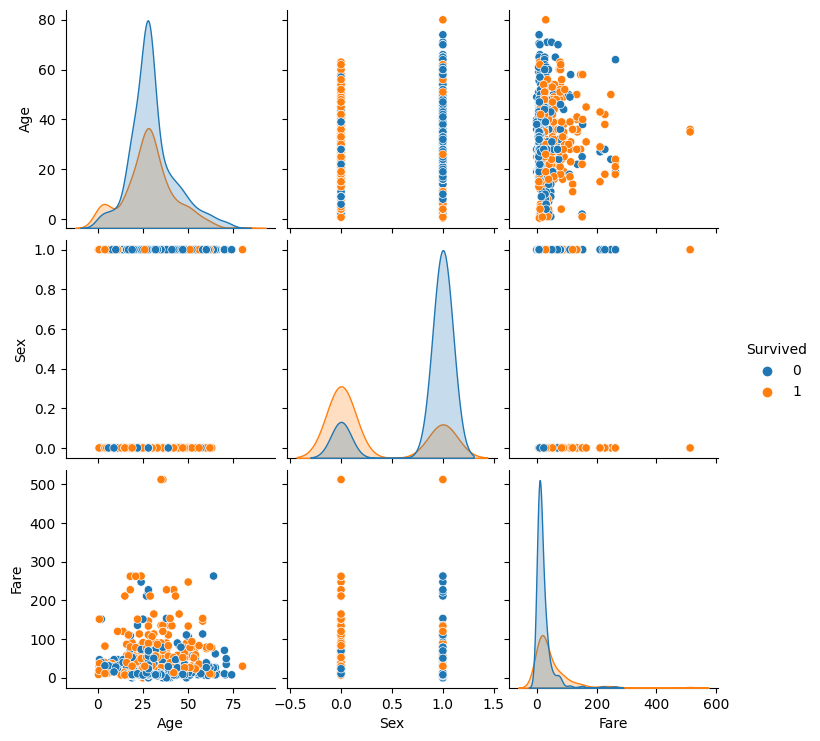

In [6]:
sns.pairplot(dataframe[["Age", "Sex", "Fare", "Survived"]], hue="Survived")

### Split the data

In [7]:
RANDOM_SEED = 42  # Set a random seed for reproducibility
TEST_SIZE = 0.2  # Use 20% of the data for testing

# Prepare the dataset for training
features = ['Sex', 'Age', 'Fare']
X = dataframe[features]
Y = dataframe['Survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

## Train the Model

We'll train the model and we will use MLflow to log that model: logging a model means saving the model to a file or a database so that it can be used later for inference.

### Connect to the MLflow server

In [8]:
# Set the URI where the MLflow server is running
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)
print("✅ Successfully connected to the MLflow server")

✅ Successfully connected to the MLflow server


### Create the experiment

In [9]:
EXPERIMENT_NAME = "Titanic Linear Regression"  # change this to your experiment name


# Create an experiment if it doesn't exist
try:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    print(f"✅ Created '{EXPERIMENT_NAME}'!")
except mlflow.exceptions.RestException:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    print(f"✅ Experiment '{EXPERIMENT_NAME}' already exists!")

experiment = mlflow.get_experiment(experiment_id)

✅ Experiment 'Titanic Linear Regression' already exists!


### Train the model and log it to MLflow

In [10]:
run_name = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=run_name,
) as run:
    
    # Train the logistic regression model
    model = LogisticRegression(random_state=RANDOM_SEED)
    model.fit(X_train.values, y_train)

    # Log the model itself to MLflow
    mlflow.sklearn.log_model(model, "model")

    # Print the run ID
    print(f"Run ID: {run.info.run_id}")

Run ID: f14b6da63a47497eb837518537dfcdb2


/usr/local/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
